In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="8"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce, partial
from collections.abc import Iterable
import traceback

# %matplotlib inline
# import matplotlib.pyplot as plt
# import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In file_utils.py: default_cache_path = /raid3/xd/.cache/torch/hub


In [3]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence    
from fn import _ as __
from collections import namedtuple 

In [4]:
from utils import *
from child_utils import *
from common_utils import *
# from model_utils import *

In [5]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [7]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B', 'EleutherAI/gpt-neox-20b', 
                   'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[1:2]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
#         model = model_cls.from_pretrained(model_name, cache_dir=cache_dir, proxies=proxies)#, low_cpu_mem_usage=True)
        model = model_cls.from_pretrained(model_name, cache_dir=cache_dir, device_map="auto", load_in_8bit=True)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
        models[model_name] = model, tokenizer

EleutherAI/gpt-neox-20b ... In huggingface_hub.file_download.cached_download: url = https://huggingface.co/EleutherAI/gpt-neox-20b/resolve/main/config.json
done 0:01:43.205725


In [32]:
text = 'Pip and conda also differ in how dependency relationships within an environment are fulfilled. When installing packages, pip installs dependencies in a recursive, serial loop. No effort is made to ensure that the dependencies of all packages are fulfilled simultaneously. This can lead to environments that are broken in subtle ways, if packages installed earlier in the order have incompatible dependency versions relative to packages installed later in the order. In contrast, conda uses a satisfiability (SAT) solver to verify that all requirements of all packages installed in an environment are met. This check can take extra time but helps prevent the creation of broken environments. As long as package metadata about dependencies is correct, conda will predictably produce working environments.'
input_ids = tokenizer.encode(text, return_tensors='pt')
input_ids = torch.cat([input_ids] * 1, dim=-1)
input_ids.size()

torch.Size([1, 144])

In [51]:
with torch.no_grad(): outputs = model(input_ids.to('cuda'))

0 <class 'int'>
bb
last_hidden_state <class 'str'>
aa


In [53]:
d = OrderedDict([('a', 1), ('b', 2)])

In [54]:
d.a

AttributeError: 'collections.OrderedDict' object has no attribute 'a'

In [52]:
outputs.items()

odict_items([('logits', tensor([[[37.1250,  2.7246, 38.6250,  ...,  4.0781,  3.6250,  4.1758],
         [57.4688,  5.2422, 60.7188,  ...,  5.6406,  5.4258,  6.2266],
         [61.0000,  3.9336, 60.7500,  ...,  4.3867,  4.6641,  4.8594],
         ...,
         [62.0312,  2.8086, 60.6250,  ...,  3.3965,  3.6895,  4.1445],
         [70.5625,  3.2188, 71.0000,  ...,  3.2285,  2.9238,  4.2148],
         [70.3750,  3.9570, 61.0000,  ...,  4.5234,  4.2070,  5.2070]]],
       device='cuda:0', dtype=torch.float16))])

In [36]:
del outputs; torch.cuda.empty_cache()

In [564]:
import openai
openai.api_key = open('/nas/xd/projects/openai_api_keys.txt').readlines()[-1].split()[0]
# response = openai.Completion.create(engine='text-davinci-002', prompt=text, #'Once upon a time',
#     max_tokens=20, echo=True, logprobs=5)
# print(response.choices[0].text)

In [408]:
def get_openai_model(engine):
    def forward(input_ids):#, attention_mask=None):
        text = tokenizer.decode(input_ids[0])
        response = openai.Completion.create(engine=engine, prompt=text, max_tokens=0, echo=True, logprobs=5)
        return Outputs(logits=response.choices[0].logprobs)
    return forward
    
# tokenizer0 = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
engines = ['text-babbage-001', 'text-curie-001', 'text-davinci-002']
for engine in engines: models[engine] = get_openai_model(engine), tokenizer0

In [13]:
prompt_token = 'Ġ!'; prompt_id = tokenizer._convert_token_to_id(prompt_token)
bop_str = 'Instruction: '; bop_id = tokenizer.encode(bop_str)[0]  # 'Inst'
eop_str = '. For example:'; eop_id = tokenizer.encode(eop_str)[2] # 'Ġexample'
bos_id = tokenizer._convert_token_to_id('Ġ->')
eos_id = tokenizer._convert_token_to_id('Ċ')


class CHILDDataset(Dataset):
    def __init__(self, input_strs, tokenizer):
        if tokenizer.pad_token is None: tokenizer.pad_token = '!'
        self.inputs = tokenizer.batch_encode_plus(input_strs, add_special_tokens=False, padding=True, return_tensors='pt')
        input_ids = self.inputs.input_ids
        self.labels = torch.ones_like(input_ids) * (-100)
        for bi in range(input_ids.size(0)):
            bop_idx = (input_ids[bi] == bop_id).nonzero().squeeze(1)
            eop_idx = (input_ids[bi] == eop_id).nonzero().squeeze(1)
            if len(bop_idx) > 0:
                assert len(bop_idx) == 1 and len(eop_idx) == 1
                bop_idx, eop_idx = bop_idx.item(), eop_idx.item()
                input_ids[bi, bop_idx: eop_idx + 2] *= -1  # use prompt embedding for prompt tokens
            
            bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
            eos_indices = (input_ids[bi] == eos_id).nonzero()[-len(bos_indices):].squeeze(1)
            for i, (bos_i, eos_i) in enumerate(zip(bos_indices.tolist(), eos_indices.tolist())):
                assert eos_i > bos_i + 1
                if i >= 2: self.labels[bi, bos_i + 1: eos_i] = input_ids[bi, bos_i + 1: eos_i]

    def __len__(self):
        return len(sel f.inputs['input_ids'])

    def __getitem__(self, i):
        return {'input_ids': self.inputs['input_ids'][i],
                'attention_mask': self.inputs['attention_mask'][i],
                'labels': self.labels[i]}

In [299]:
class WrappedEmbedding(nn.Module):
    def __init__(self, 
                wte: nn.Embedding,
                prompt_id: int = None,
                prompt_len: int = 10, 
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        super(WrappedEmbedding, self).__init__()
#         self.wte = wte
#         self.prompt_id = prompt_id
#         self.prompt_len = prompt_len
        self.__dict__.update(locals()); del self.self
        if self.prompt_id is not None:
            self.prompt_embedding = nn.parameter.Parameter(
                self.initialize_embedding(random_range, initialize_from_vocab)).to(self.wte.weight.device)
        else:
            self.prompt_embedding = nn.Embedding(self.prompt_len, self.wte.weight.size(1)).to(self.wte.weight.device)
            assert initialize_from_vocab
            self.init_prompt_embedding_()
#             self.prompt_embedding.weight.data = self.initialize_embedding(random_range, initialize_from_vocab)     
            
    def initialize_embedding(self, random_range: float = 0.5, initialize_from_vocab: bool = True):
        if initialize_from_vocab: return self.wte.weight[:self.prompt_len].clone().detach()
        return torch.FloatTensor(self.prompt_len, self.wte.weight.size(1)).uniform_(-random_range, random_range)
    
    def init_prompt_embedding_(self):
        self.prompt_embedding.weight.data[:] = self.wte.weight[:self.prompt_len]
            
    def forward(self, input_ids):
        if self.prompt_id is not None:
            input_embeds = self.wte(input_ids)
            input_embeds[input_ids == self.prompt_id] = self.prompt_embedding.expand(input_embeds.size(0), -1, -1)
        else: # adapted from cpm-2
            prompt_mask = input_ids < 0
            prompt_ids = -input_ids * prompt_mask
            assert torch.all(prompt_ids < self.prompt_len)
            p_embeds = self.prompt_embedding(prompt_ids) * prompt_mask.float().unsqueeze(-1)
            input_ids = input_ids * ~prompt_mask
            w_embeds = self.wte(input_ids) * (~prompt_mask).float().unsqueeze(-1)
            input_embeds = w_embeds + p_embeds
        return input_embeds

In [ ]:
# adapted from cpm-2: https://github.com/TsinghuaAI/CPM-2-Finetune/blob/master/utils.py#L133-L164
def get_params_for_prompt_optimization(module: nn.Module):
    params = []
    for t in module.named_modules():
        if "prompt_embedding" in t[0]:
            params.append({'params': [p for p in list(t[1]._parameters.values()) if p is not None]})
    for t in module.named_parameters():
        if "prompt" not in t[0]:
            t[1].requires_grad_(False)    
    return params

def create_optimizer(model, training_args):
    from torch.nn.parallel.distributed import DistributedDataParallel as DDP
    while isinstance(model, (DDP, )): model = model.module
    we.init_prompt_embedding_()
    param_groups = get_params_for_prompt_optimization(model)
    optimizer = AdamW(param_groups, lr=training_args.learning_rate, 
                      betas=(training_args.adam_beta1, training_args.adam_beta2),eps=training_args.adam_epsilon)
    return optimizer

In [249]:
wte = model.get_input_embeddings()
if hasattr(wte, 'wte'): wte = wte.wte  # already been wrapped
we = WrappedEmbedding(wte, prompt_len=10000)
model.set_input_embeddings(we)

In [8]:
def verbalize(obj):
    if type(obj) == bool: return 'Yes' if obj else 'No'
    return str(obj)
    
def make_query_str(instruction, query):
    if instruction is None and query is None: return ''
    s = '.'
    if instruction is not None: s = s + ' ' + instruction
    if query is not None:
        if type(query) in [int, bool, str]: query = [query]
        if type(query) == dict:
    #         return '. ' + '{' + ','.join([' %s: %s' % (str(k), str(v)) for k, v in query.items()]) + ' }'
            s = s + ' ' + '{' + ','.join([' replace %s with %s' % (str(k), str(v)) for k, v in query.items()]) + ' }'
        elif type(query) in [list,]:
            s = s + ' ' + ' '.join([str(i) for i in query])
    return s

def make_example_str(example, with_instruction=False):
    instruction, l, query, ans = example
    if type(ans) not in [Sequence, list]: ans = [ans]
    ans = [verbalize(a) for a in ans]
    return '%s -> %s' % (' '.join(l) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))

def sample_rand_len(vocab, k): return sample(vocab, k=randint(1, k))

In [ ]:
def p2r(p): p = seq(p); return p.zip(p.inits().zip(p.tails()))#.slice(1, p.len() - 1)
def neighbour(direction, k=1): return lambda x: x[direction][k]
def prev(k=1): return neighbour(0, k)
def next(k=1): return neighbour(1, k)
prevs, nexts = __[0][1:], __[1][1:]
beside = lambda x: (x[0][1], x[1][1])

In [ ]:
def ith_element(cxt, query): return seq(cxt).slice(1, 2)[0]
def besides(cxt, query): return seq(cxt).difference(query)[0]
# def besides_query(cxt, vocab): return cxt.a(sample, 2), cxt.list()
def get_poset(e): return tuple([p for p in posets if e in p][0])
def special(cxt, query): return seq(cxt).group_by(get_poset).map(__[1]).find(lambda x: len(x) == 1)[0]
# def special_cxt(vocab, k=3): sample(vocab[0], k - 1) + sample(vocab[1], 1)

def after_query(r, p):
    # e = r.dom().init().a(choice)
    e = choice(r.dom().init().tail().list())
    options = r.image(e).map(beside)[0].a(sample, 2)
    return e, options

def before_query(r, p):
    # e = r.dom().tail().a(choice)
    e = choice(r.dom().init().tail().list())
    options = r.image(e).map(beside)[0].a(sample, 2)
    return e, options

def after(r, q): return r.image(q).map(next())[0]
def before(r, q): return r.image(q).map(prev())[0]
def between(r, q): 
    return r.image(q[0]).map(nexts)[0].intersection(r.image(q[1]).map(prevs)[0]).union(
        r.image(q[0]).map(prevs)[0].intersection(r.image(q[1]).map(nexts)[0]))
    
def monotone_map_cxt(vocab):
    P, p = vocab
    R = p2r(P)
    E1 = R.dom().init().tail().a(choice)
    E2 = R.image(E1).map(beside)[0].a(choice)
    return R, E1, E2

def monotone_map_query(cxt, vocab):
    P, p = vocab
    r = p2r(p)
    e1 = r.dom().init().tail().a(choice)
    options = r.image(e1).map(beside)[0]
    return (r, e1), options

def monotone_map(cxt, query, reverse=False):
    R, E1, E2 = cxt
    r, e1 = query
    return r.image(e1).map(
        seq([prev(), next()]).find(lambda f: (E2 in R.image(E1).map(f)[0]) != reverse)  # reverse = not in. too tricky
    )[0]
    
tasks = [
    (ith_element, None, partial(sample, k=3), None),
    (besides, None, partial(sample, k=3), lambda cxt, vocab: (sample(cxt, 2), cxt)),
    (special, lambda: sample(posets[1:3], 2), lambda vocab: sample(sample(vocab[0], 2) + sample(vocab[1], 1), 2 + 1), None),
    
    (after, lambda: choice(closed_posets[:]), p2r, after_query, lambda r: ''),
    (before, lambda: choice(closed_posets[:]), p2r, before_query, lambda r: ''),
    (between, lambda: choice(posets), p2r, lambda r, p: r.image(r.dom().init().tail().a(choice)).map(beside)[0].a(sample, 2), lambda r: ''),
    (partial(monotone_map, reverse=False), lambda: sample(posets, 2), monotone_map_cxt, monotone_map_query),
    (partial(monotone_map, reverse=True), lambda: sample(closed_posets, 2), monotone_map_cxt, monotone_map_query),
    (lookup, )
]

In [15]:
def _str(l, vocab=None, sep=' '):
    if l is None: return ''
    if isinstance(l, str) or not isinstance(l, Iterable): l = [l]
    l = [e for e in l if not my_isinstance(e, Sequence)] #type(e).__name__ != 'Sequence']
    if isinstance(l, (dict, OrderedDict)): l = [f'{k}: {v}' for k, v in l.items()]
    return sep.join(str(i) for i in l)

def options2str(options): return '[' + ' | '.join(options) + ']'
# def options2str(options): return ' or '.join(options) + '?'

In [ ]:
# I = Identity; M = Mophism; A = Aggregation; C = CMP; G = GroupBy; l = local
patterns = ['M', 'A?', 'IA', 'MA',
    'IlI', 'MlI', 'IlM', 'MlM', 'IlMlI',
    'IlA', 'MlA', 'IlC', 'MlC', 'AlI', 'GIlI']

In [165]:
def promptize(s): return bop_str + s + eop_str
    
def make_examples(task, nrows=4, vocab_for_each_row=True, options_position=None):
    # if full_vocab is None: full_vocab = string.ascii_uppercase + string.ascii_lowercase #+ string.digits
    # transform_fn, vocab_fn, sample_fn, query_fn = task[:4]
    # if query_fn is None: query_fn = lambda *_: (None, None)
    # if vocab_fn is None: vocab_fn = lambda: full_vocab
    vocab_fn, example_gen_fn = task[:2]

    vocabs, examples = [], []
    qa_set = set() # for dedup
    if not vocab_for_each_row: vocab = vocab_fn()
    for i in range(nrows * 2):
        if vocab_for_each_row: vocab = vocab_fn()
        # cxt = sample_fn(vocab)
        # query, options = query_fn(cxt, vocab)
        # ans = transform_fn(cxt, query)
        cxt, query, candidates, ans = example_gen_fn(vocab)
        if isinstance(query, list): query = tuple(query)
        if (query, ans) not in qa_set:
            qa_set.add((query, ans))
            vocabs.append(vocab)
            examples.append([cxt, query, candidates, ans])
        if len(examples) == nrows: break
    return vocabs, examples

def make_input_str(task, vocabs, examples, options_position=None):
    task += (_str,) * (2 + 3 - len(task))
    cxt2str, query2str, ans2str = task[2:]
    def example2str(vocab, example, with_instruction=False):
        cxt, query, options, ans = example
        strs = [cxt2str(cxt, vocab), query2str(query, vocab)]
        if options_position is not None: strs.insert(options_position, options2str(options))
        return '. '.join(s for s in strs if s != '') + ' -> ' + ans2str(ans)

    text = '\n'.join(example2str(v, e) for v, e in zip(vocabs, examples)) + '\n'
    return text

def make_input_str_old(task, examples, options_position=None):
    task += (_str,) * (2 + 3 - len(task))
    cxt2str, query2str, ans2str = task[2:]

    def example2str(example, with_instruction=False):
        cxt, query, options, ans = example
        strs = [cxt2str(cxt), query2str(query)]
        if options_position is not None: strs.insert(options_position, options2str(options))
        # strs = [options2str(options)] + strs if options_position == 'pre' else strs + [options2str(options)]
        return '. '.join(s for s in strs if s != '') + ' -> ' + ans2str(ans)

    desc = promptize(instruction) + '\n' if False else ''
    text = '\n'.join(example2str(e) for e in examples)
    text = '\n' + desc + text + '\n'
    return text

In [550]:
def MlM_gen(vocab, cxt_len=None, rel_names=None):
    s0, s1 = vocab
    rel0, rel0_dom, rel0_codom, is_rel0 = s0.get_rel_fns(rel_names[0])
    rel1, rel1_dom, rel1_codom, is_rel1 = s1.get_rel_fns(rel_names[1])
    distracting_rel_names = [] #[r for r in set(s0.rel_names) - {rel_names[0]} if random.random() > 0.5]
    dom = set.intersection(*[set(getattr(s0, r + '_dom')()) for r in [rel_names[0]] + distracting_rel_names])
    query = choice(list(dom))

    all_rels = [rel0] #[getattr(s0, r) for r in s0.rel_names]
    candidate_rels = [rel0] + [getattr(s0, r) for r in distracting_rel_names]
    candidates0 = [choice(r(query)) for r in candidate_rels]
    candidates0 += sample(list(set(s0.el()) - set(join_lists([r(query) for r in all_rels]))), 
        cxt_len - len(candidates0))
    candidates1 = sample(rel1_dom(), cxt_len)
    cxt = list(zip(sample(candidates0, cxt_len), candidates1))
    def transform_fn(cxt, query): return choice(rel1(seq(cxt).find(lambda x: is_rel0(query, x[0]))[1]))
    ans = transform_fn(cxt, query)
    return cxt, query, candidates1, ans

def MlM_gen(rels, cxt_len=None):
    hop = 0
    query = choice(list(rels[hop][0].dom()))
    candidates0 = [choice(r.f(query)) for r in rels[hop][:1]]
    # candidates0 = [choice(r.f(query)) for i, r in enumerate(rels[hop]) if i == 0 or random() > 0.5] # w/ distractors
    candidates0 += sample(list(rels[hop][0].codom() - set(join_lists([r.f(query) for r in rels[hop]]))), 
        cxt_len - len(candidates0))

    hop = 1
    candidates1 = sample(list(rels[hop][0].dom()), cxt_len)
    cxt = sample(list(zip(candidates0, candidates1)), cxt_len)

    def transform_fn(cxt, query):
        hop = 0; ans = seq(cxt).find(lambda x: rels[hop][0].b(query, x[0]))[1]
        hop = 1; ans = choice(rels[hop][0].f(ans))
        return ans
    ans = transform_fn(cxt, query)
    return cxt, query, [x[1] for x in cxt], ans

def IlMlI_gen(rels, cxt_len=None):
    hop = 0
    query = choice(list(rels[hop][0].dom()))
    candidates0 = [choice(r.f(query)) for r in rels[hop][:1]]
    candidates0 += sample(list(rels[hop][0].codom() - set(join_lists([r.f(query) for r in rels[hop]]))), 
        cxt_len - len(candidates0))
    candidates0 = candidates0[:1] + sample(candidates0[1:], cxt_len - 1)

    hop = 1
    query1 = choice(list(rels[hop][0].dom()))
    candidates1 = [query1] + [choice(r.f(query1)) for r in rels[hop][:1]]
    candidates1 += sample(list(rels[hop][0].codom() - {query1} - set(join_lists([r.f(query1) for r in rels[hop]]))), 
        cxt_len - len(candidates1))
    # assert len(candidates1) == len(set(candidates1)), str(candidates1)
    cxt = sample(list(zip(candidates0, candidates1)), cxt_len)
    
    def transform_fn(cxt, query):
        hop = 0; ans = seq(cxt).find(lambda x: rels[hop][0].b(query, x[0]))[1]
        hop = 1; ans = seq(cxt).find(lambda x: x[0] != query and rels[hop][0].b(ans, x[1]))[0]
        hop = 2; ans = choice(rels[hop][0].f(ans))
        return ans
    ans = transform_fn(cxt, query)
    return cxt, query, [x[0] for x in cxt], ans

def g2bc(g_fn, rels, cxt_len=None, labels=['T', 'F']):
    cxt, query, candidates, ans = g_fn(rels, cxt_len=cxt_len)
    return (cxt, choice(list(set(candidates) - {query})), labels, labels[1]) \
        if random() > 0.5 else (cxt, query, labels, labels[0])

def g2bc(g_fn, labels=['T', 'F']):
    def wrapped(*args,**kwargs):
        cxt, query, candidates, ans = g_fn(*args,**kwargs)
        return (cxt, (query, choice(list(set(candidates) - {query, ans}))), labels, labels[1]) \
            if random() > 0.5 else (cxt, (query, ans), labels, labels[0])
    return wrapped

def _item2str(item, vocab=None): return f'{item[0]}: {item[1]}'
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        if vocab[0] == clock_of_day: prep = 'at'
        elif vocab[0] == days_of_week: prep = 'on'
        elif vocab[0] == months: prep = 'in'
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def _cxt2str(cxt, vocab=None, item2str=_item2str): return ', '.join([item2str(item, vocab=vocab) for item in cxt])
def _query2str(query, vocab=None): return f'{query} same as'
def lookup_query2str(query, vocab=None, rel_name=None):
    return f'just after {query}'
    if vocab[0] in [clock_of_day, days_of_week, months]:
        if vocab[0] == clock_of_day: prep = 'at'
        elif vocab[0] == days_of_week: prep = 'on'
        elif vocab[0] == months: prep = 'in'
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'
tasks = [
    # (lambda: (Poset(choice([days_of_week, months, digits, years, uppercase[:7]])), EqSet(persons)),
    (lambda: [[EqSet(persons).equal], [SymSet(frames).equal]],
        partial(g2bc(MlM_gen), cxt_len=3),
        partial(_cxt2str, item2str=lambda item, vocab: f'{item[1]} {item[0]}'),
        lambda query, vocab: f'{query[0]} is {query[1]}?'
    ), 
    (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]],
        partial(g2bc(IlMlI_gen), cxt_len=3),
        partial(_cxt2str, item2str=lambda item, vocab: f'{item[0]} {item[1]}'),
        lambda query, vocab: f'{query[0]} and {query[1]} are same?'
    ),
]

In [566]:
# task = tasks[0]; nrows=32; k_shot=5
# vocabs, _examples = make_examples(task, nrows=nrows)

# answer_indices = [cands.index(ans) for _, _, cands, ans in _examples]
# Counter(answer_indices).most_common()
# label_probs = F.one_hot(torch.LongTensor(answer_indices))
# _ = plt.figure(figsize=(10, 0.7));
# _ = sns.heatmap(label_probs.T, cbar=False); plt.show()

# text = make_input_str(task, vocabs, _examples)
nrows_ = 8
answer_indices_ = [cands.index(ans) for _, _, cands, ans in _examples[:nrows_]]
text_ = make_input_str(task, vocabs, _examples[:nrows_])
print(len(tokenizer.tokenize(text_))); print(text_[:3000])

160
manual Ricardo, normal Sara, cerebral Jaxx. Jaxx is cerebral? -> T
interesting Catherine, compatible Magnus, effective Alayna. Alayna is compatible? -> F
rational Dangelo, confident Meghan, legal Luna. Meghan is legal? -> F
partial Rylee, unpopular John, extraordinary Ayla. Ayla is extraordinary? -> T
boring Quincy, gradual Amina, smart Sara. Sara is gradual? -> F
warm Ada, urban Kori, sensitive Krew. Kori is urban? -> T
rural Juliette, immortal Amiyah, intelligent Demi. Amiyah is intelligent? -> F
abundant Noelle, central Brooklyn, foreign Harmony. Noelle is abundant? -> T



 ĠT 0.001 {' Yes': 0.223, ' J': 0.047, '\n': 0.04} 	 manual Ricardo, normal Sara, cerebral Jaxx. Jaxx is cerebral? -> T
*ĠF 0.556 {' F': 0.556, ' T': 0.361, ' Y': 0.014} 	 interesting Catherine, compatible Magnus, effective Alayna. Alayna is compatible? -> F
 ĠF 0.49 {' T': 0.494, ' F': 0.49, ' ?': 0.003} 	 rational Dangelo, confident Meghan, legal Luna. Meghan is legal? -> F
*ĠT 0.995 {' T': 0.995, ' F': 0.002, 'T': 0.002} 	 partial Rylee, unpopular John, extraordinary Ayla. Ayla is extraordinary? -> T
*ĠF 0.996 {' F': 0.996, ' T': 0.002, 'F': 0.001} 	 boring Quincy, gradual Amina, smart Sara. Sara is gradual? -> F
*ĠT 0.999 {' T': 0.999, 'T': 0.001, ' F': 0.0} 	 warm Ada, urban Kori, sensitive Krew. Kori is urban? -> T
*ĠF 0.62 {' F': 0.62, ' T': 0.373, 'T': 0.001} 	 rural Juliette, immortal Amiyah, intelligent Demi. Amiyah is intelligent? -> F
*ĠT 0.999 {' T': 0.999, 'T': 0.001, ' F': 0.0} 	 abundant Noelle, central Brooklyn, foreign Harmony. Noelle is abundant? -> T


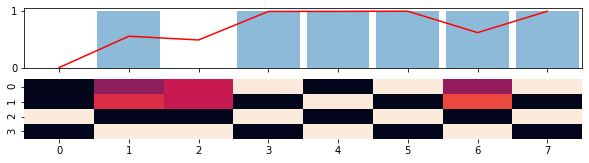

text-davinci-002 160 0.09767799912 1.0


In [568]:
openai.api_key = open('/nas/xd/projects/openai_api_keys.txt').readlines()[-2].split()[0]
model_names = ['EleutherAI/gpt-j-6B', 'EleutherAI/gpt-neox-20b', #'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B', 
    'text-curie-001', 'text-davinci-002'][-1:]
for model_name in model_names:
    model, tokenizer = models[model_name]
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text if 'text' not in model_name else text_, tokenizer, k_shot=k_shot)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in e[2]] for e in _examples]
    with torch.no_grad(): logits = model(input_ids).logits

    loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
        examples, tokenizer, logits, bos_indices, eos_indices, answers, labels,
        candidates=candidates, topk=3, verbose=len(model_names) <= 1)

    f, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 2.4), sharex=True)
    x = [i + 0.5 for i in range(nrows if 'text' not in model_name else nrows_)] # to align with sns.heatmap
    _ = ax0.bar(x, top1_corrects, width=0.9, alpha=0.5);
    _ = ax0.plot(x, answer_probs, color='r');
    label_probs = F.one_hot(torch.LongTensor(answer_indices if 'text' not in model_name else answer_indices_))
    _ = sns.heatmap(torch.cat([torch.Tensor(candidate_probs), label_probs], dim=1).T, cbar=False, ax=ax1);
    plt.show()
    print(model_name, len(tokens), loss, np.array(top1_corrects[k_shot:]).mean())

In [155]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

[('▁The', 37),
 ('▁capital', 1784),
 ('▁of', 13),
 ('▁Canada', 1894),
 ('▁is', 19),
 ('</s>', 1)]

'Ottawa. It is the largest city in Canada'

In [478]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [197]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

EleutherAI/gpt-j-6B ... done 0:00:01
* C 0.842 {' C': 0.842, ' A': 0.041, ' B': 0.04} 	 D -> C
* Thursday 0.778 {' Thursday': 0.778, ' Wednesday': 0.064, ' Friday': 0.063} 	 Friday -> Thursday
* a 0.742 {' a': 0.742, ' c': 0.051, ' A': 0.036} 	 b -> a
* four 0.472 {' four': 0.472, ' three': 0.246, ' one': 0.105} 	 five -> four
tensor(0.3677, grad_fn=<NllLossBackward>) True 

0.3677041530609131


In [24]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [385]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

Instruction: replace with the other. For example:
G H G G G -> H G H H H
I I I I M -> M M M M I
A A F A A -> F F A F F
9 9 9 I I -> I I I 9 9

Instruction: replace with the other. For example:
V Q Q V V -> Q V V Q Q
G L L G L -> L G G L G
G 2 2 2 G -> 2 G G G 2
I I Z Z Z -> Z Z I I I

Instruction: replace with the other. For example:
R H H H R -> H R R R H
B 9 9 B B -> 9 B B 9 9
D 2 2 2 D -> 2 D D D 2
A A A A W -> W W W W A



In [368]:
sum(s.count('Yes') for s in input_strs)

370

In [322]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [121]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [329]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [330]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [333]:
trainer.place_model_on_device

True

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [6]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])